<a href="https://colab.research.google.com/github/Kaohtp/B23DCVT201_PhungThuHuong_BTL2_Python/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cuda:0
Epoch [1/300], Train Loss: 1.7388, Train Acc: 42.60%, Val Loss: 1.5665, Val Acc: 52.41%, LR: 1.0e-03, Duration: 22.07s
Epoch 1: New best model saved (Val Loss: 1.5665)
Epoch [2/300], Train Loss: 1.4710, Train Acc: 56.10%, Val Loss: 1.4711, Val Acc: 55.82%, LR: 1.0e-03, Duration: 19.40s
Epoch 2: New best model saved (Val Loss: 1.4711)
Epoch [3/300], Train Loss: 1.3622, Train Acc: 62.07%, Val Loss: 1.2877, Val Acc: 65.23%, LR: 1.0e-03, Duration: 20.18s
Epoch 3: New best model saved (Val Loss: 1.2877)
Epoch [4/300], Train Loss: 1.3020, Train Acc: 64.76%, Val Loss: 1.2704, Val Acc: 66.16%, LR: 1.0e-03, Duration: 20.41s
Epoch 4: New best model saved (Val Loss: 1.2704)
Epoch [5/300], Train Loss: 1.2543, Train Acc: 67.59%, Val Loss: 1.2301, Val Acc: 68.44%, LR: 1.0e-03, Duration: 20.12s
Epoch 5: New best model saved (Val Loss: 1.2301)
Epoch [6/300], Train Loss: 1.2226, Train Acc: 68.91%, Val Loss: 1.1721, Val Acc: 71.31%, LR: 1.0e-03, Duration: 20.36s
Epoch 6: New best mo

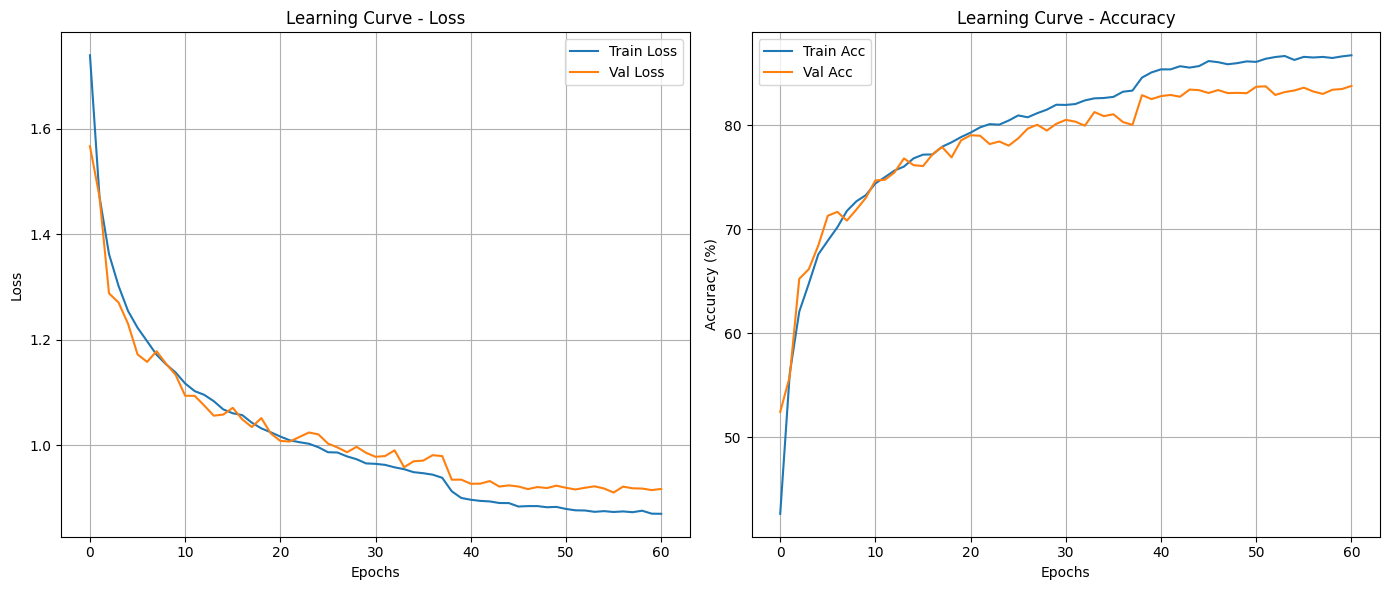

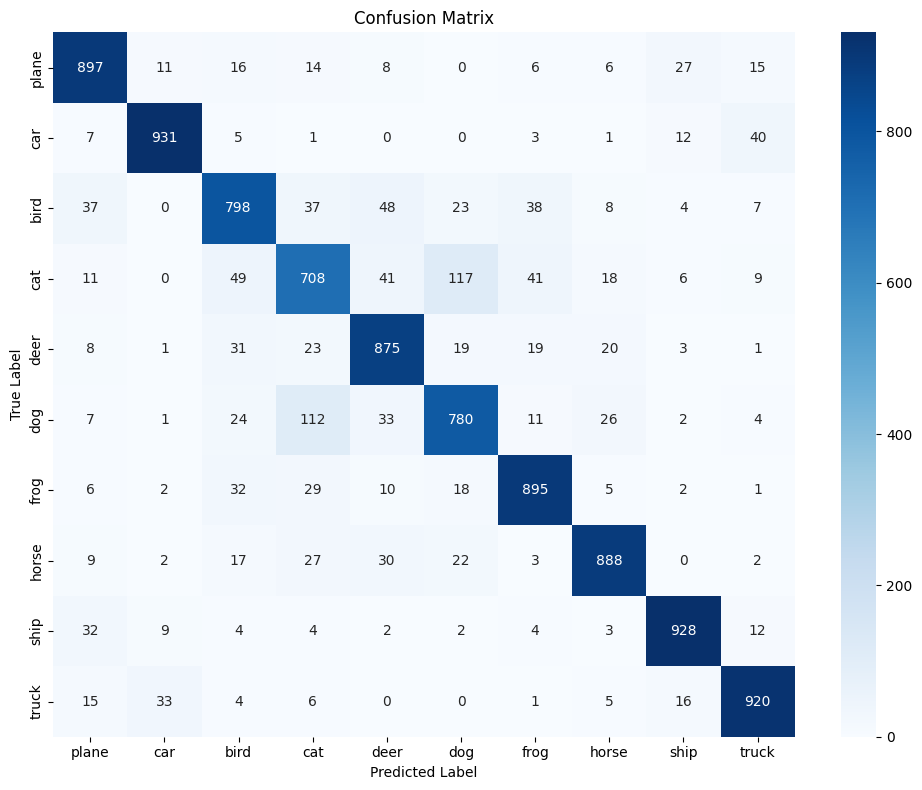

In [3]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import logging
import time
from datetime import datetime
import sys
from torch.utils.data import random_split
# === Hyperparameters ===
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PIN_MEMORY = DEVICE.type == 'cuda'
BATCH_SIZE = 128
LR = 0.001
EPOCHS = 300
PATIENCE = 5
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
DROPOUT_RATE = 0.5
LABEL_SMOOTHING = 0.1
WEIGHT_DECAY = 5e-4

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if DEVICE.type == 'cuda':
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Thiết lập logging
def setup_logging():
    log_dir = 'logs'
    os.makedirs(log_dir, exist_ok=True)
    log_file = os.path.join(log_dir, f'training_{datetime.now().strftime("%Y%m%d_%H%M%S")}.log')

    # Cấu hình logging với encoding UTF-8
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_file, encoding='utf-8'),
            logging.StreamHandler(sys.stdout)  # Sử dụng sys.stdout để hỗ trợ Unicode
        ]
    )
    return logging.getLogger(__name__)

# Tạo thư mục lưu kết quả
def create_directories():
    directories = ['results', 'models', 'plots']
    for dir_name in directories:
        os.makedirs(dir_name, exist_ok=True)

# Hiển thị ảnh mẫu
def imshow(img, name):
    img = img * torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1) + torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    np_img = img.numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.savefig(os.path.join('plots', name))
    plt.close()

# === Model ===
class CNN(nn.Module):
    def __init__(self, num_classes=len(CLASSES), dropout_rate=DROPOUT_RATE):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 4 * 4)
        x = F.relu(self.bn_fc1(self.fc1(x)))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# === Data Loading ===
def get_data_loaders():
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.RandomErasing(p=0.3, scale=(0.02, 0.2), ratio=(0.3, 3.3), value='random'),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load datasets
    full_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    # Split training set
    train_size = int(0.8 * len(full_train))
    val_size = len(full_train) - train_size
    train_set, val_set = random_split(full_train, [train_size, val_size])

    # Create data loaders with optimized settings
    train_loader = torch.utils.data.DataLoader(
        train_set,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        pin_memory=PIN_MEMORY
    )
    val_loader = torch.utils.data.DataLoader(
        val_set,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory=PIN_MEMORY
    )
    test_loader = torch.utils.data.DataLoader(
        test_set,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory=PIN_MEMORY
    )

    return train_loader, val_loader, test_loader

# === Training ===
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device):
    best_val_loss = float('inf')
    patience_counter = 0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(EPOCHS):
        epoch_start_time = time.time()

        # Training
        model.train()
        train_loss = train_acc = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += (outputs.argmax(1) == targets).sum().item()

        train_loss /= len(train_loader)
        train_acc = 100 * train_acc / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = val_acc = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device, non_blocking=True), targets.to(device, non_blocking=True)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                val_acc += (outputs.argmax(1) == targets).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100 * val_acc / len(val_loader.dataset)

        # Update learning rate
        scheduler.step(val_loss)

        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        epoch_duration = time.time() - epoch_start_time
        print(f'Epoch [{epoch + 1}/{EPOCHS}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, '
              f'LR: {optimizer.param_groups[0]["lr"]:.1e}, Duration: {epoch_duration:.2f}s')

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"Epoch {epoch+1}: New best model saved (Val Loss: {val_loss:.4f})")
        else:
            patience_counter += 1
            if patience_counter >= PATIENCE:
                print(f'\nEarly stopping triggered after {epoch + 1} epochs')
                break

    return history

# === Evaluation ===
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'\nTest Accuracy: {accuracy:.2f}%')

    # Print class-wise accuracy
    cm = confusion_matrix(all_labels, all_preds)
    class_accuracies = np.zeros(len(CLASSES))
    valid_classes_mask = cm.sum(axis=1) > 0
    class_accuracies[valid_classes_mask] = 100 * cm.diagonal()[valid_classes_mask] / cm.sum(axis=1)[valid_classes_mask]

    print("\nClass-wise accuracy:")
    for i, class_name in enumerate(CLASSES):
        if cm.sum(axis=1)[i] > 0:
            print(f'Accuracy of {class_name:5s} : {class_accuracies[i]:.2f}%')

    return accuracy, all_preds, all_labels

# === Visualization ===
def plot_results(history, y_true, y_pred):
    # Plot learning curves
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Learning Curve - Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Learning Curve - Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    try:
        plt.show()
    except:
        plt.savefig('learning_curves.png', dpi=300)
    plt.close()

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASSES, yticklabels=CLASSES)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    try:
        plt.show()
    except:
        plt.savefig('confusion_matrix.png', dpi=300)
    plt.close()

def main():
    print(f"Using device: {DEVICE}")

    # Get data
    train_loader, val_loader, test_loader = get_data_loaders()

    # Initialize model and training
    model = CNN().to(DEVICE)

    criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, min_lr=1e-6)

    # Train model
    history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, DEVICE)

    # Load best model and evaluate
    model.load_state_dict(torch.load('best_model.pth'))
    acc, preds, labels = evaluate_model(model, test_loader, DEVICE)

    # Plot results
    plot_results(history, labels, preds)

if __name__ == '__main__':
    main()

# Mục mới

# Mục mới